In [15]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import joblib

from data.data_loader import DataLoader
from data.data_cleaner import DataCleaner
from data.data_explorer import DataExplorer
from data.geo_mapper import GeoMapper

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
fraud_data_path = "../data/Fraud_Data.csv"
ip_country_path = "../data/IpAddress_to_Country.csv"

In [3]:
# Create DataLoader instance
loader = DataLoader(fraud_data_path, ip_country_path)
# Load data
fraud_df, ip_country_df = loader.load_data()

In [4]:
# Check for missing values
loader.check_missing_values()

Missing values in Fraud Data:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Missing values in IP Address to Country Data:
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [5]:
# Handle missing values
fraud_df, ip_country_df = loader.handle_missing_values()

Missing values handled (rows with missing data dropped).


In [6]:
# Clean the fraud data
cleaner = DataCleaner(fraud_df)

# Remove duplicate rows
fraud_df = cleaner.remove_duplicates()

# Fix data types
fraud_df = cleaner.correct_data_types()

# Optional: check result
fraud_df.dtypes

Removed 0 duplicate rows.
Converted data types successfully.


user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


 Descriptive Statistics (Numeric Features):
             user_id                    signup_time  \
count  151112.000000                         151112   
mean   200171.040970  2015-04-20 00:56:09.511329280   
min         2.000000            2015-01-01 00:00:42   
25%    100642.500000     2015-02-18 09:52:48.500000   
50%    199958.000000            2015-04-19 04:41:30   
75%    300054.000000  2015-06-18 14:47:22.750000128   
max    400000.000000            2015-08-18 04:40:29   
std    115369.285024                            NaN   

                       purchase_time  purchase_value            age  \
count                         151112   151112.000000  151112.000000   
mean   2015-06-16 02:56:38.759952896       36.935372      33.140704   
min              2015-01-01 00:00:44        9.000000      18.000000   
25%       2015-04-18 14:41:25.500000       22.000000      27.000000   
50%       2015-06-18 13:46:17.500000       35.000000      33.000000   
75%       2015-08-17 18:48:31.500

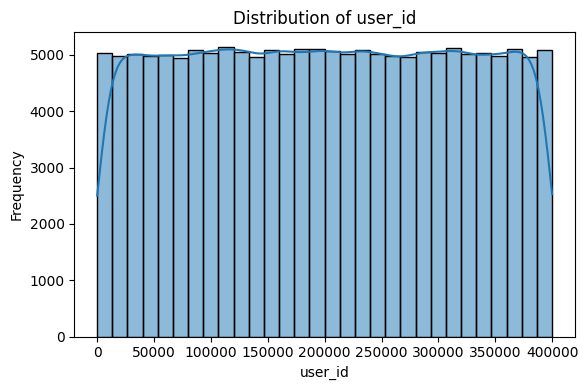

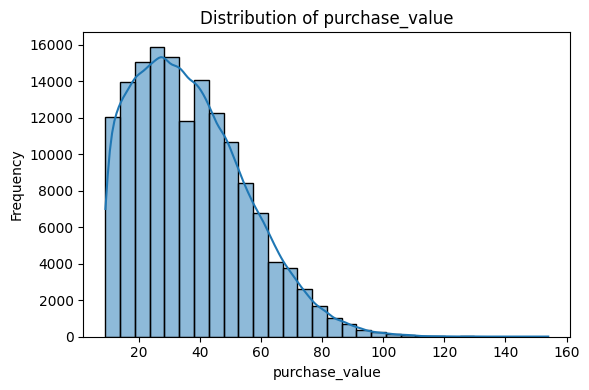

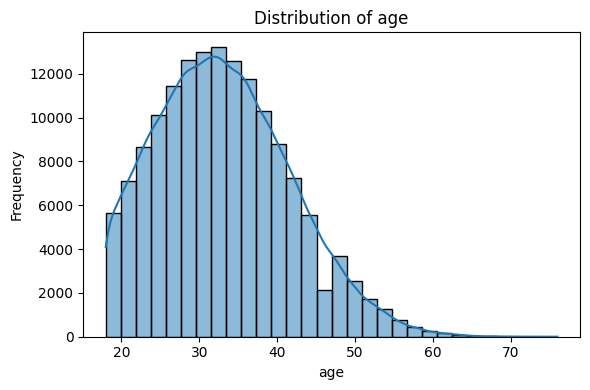

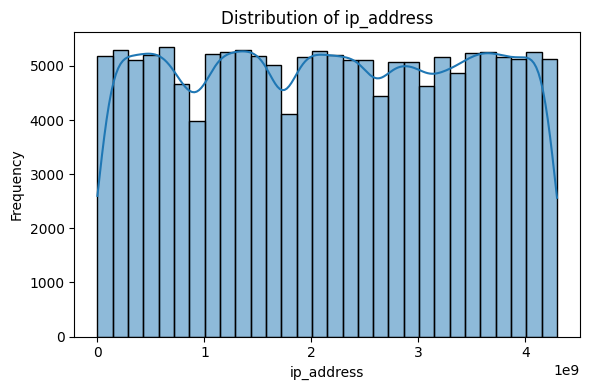

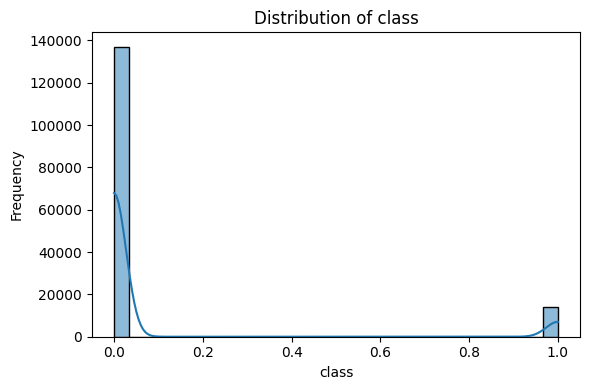

In [7]:
# Create an explorer instance
explorer = DataExplorer(fraud_df)

# Describe and summarize the data
explorer.describe_data()

# Plot histograms of numeric features
explorer.plot_distributions()

/home/liya/Desktop/KAIM/fraud-detection-for-eCommerce-w8/src/data/data_explorer.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/liya/Desktop/KAIM/fraud-detection-for-eCommerce-w8/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


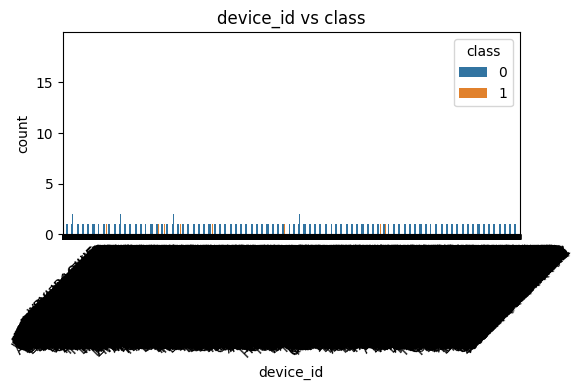

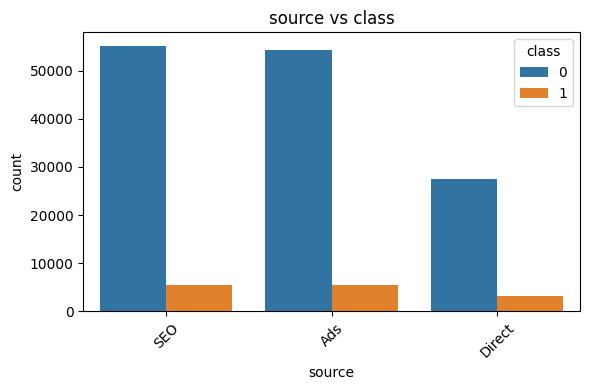

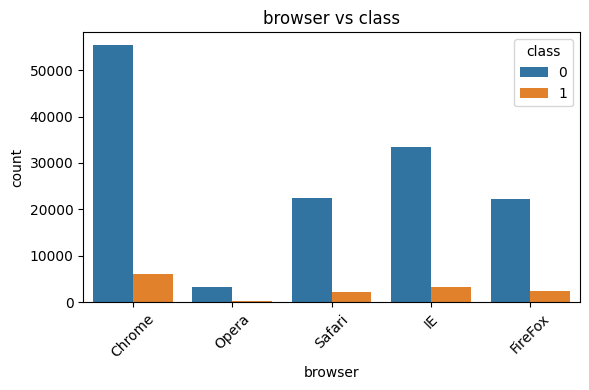

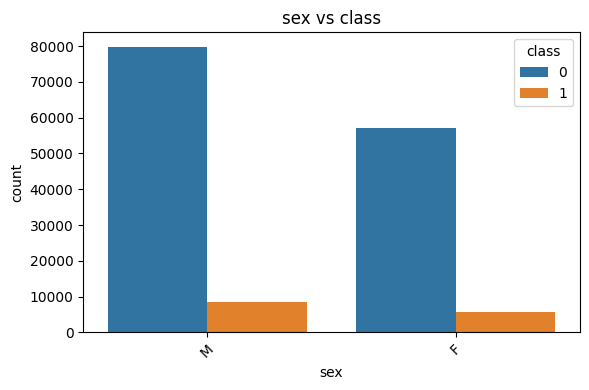

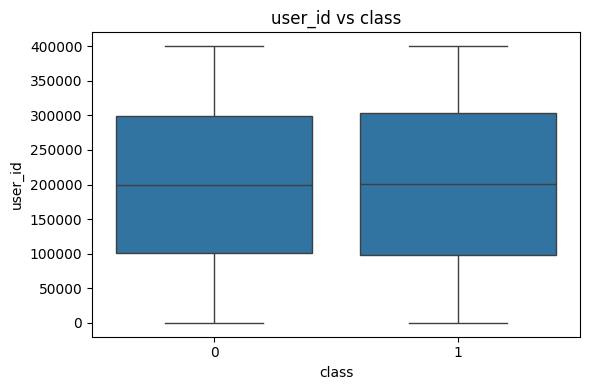

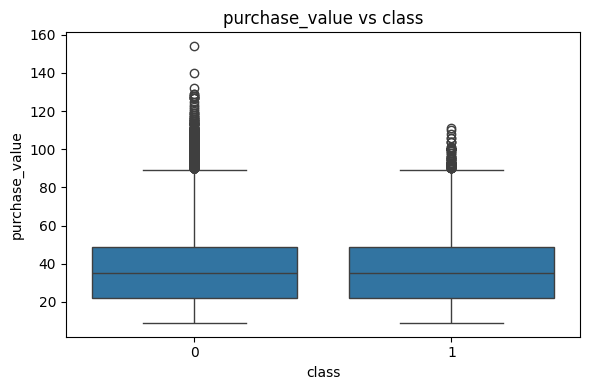

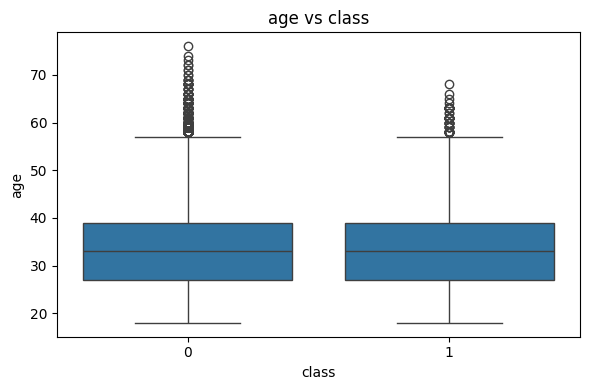

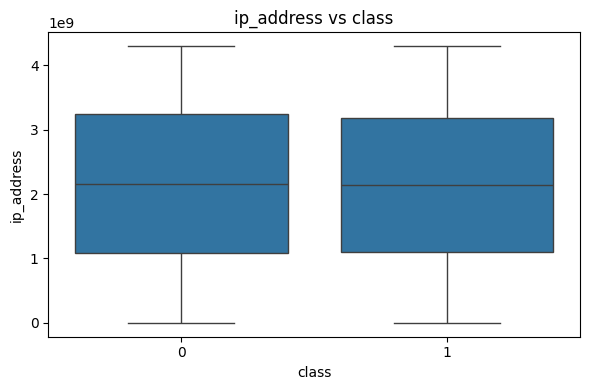

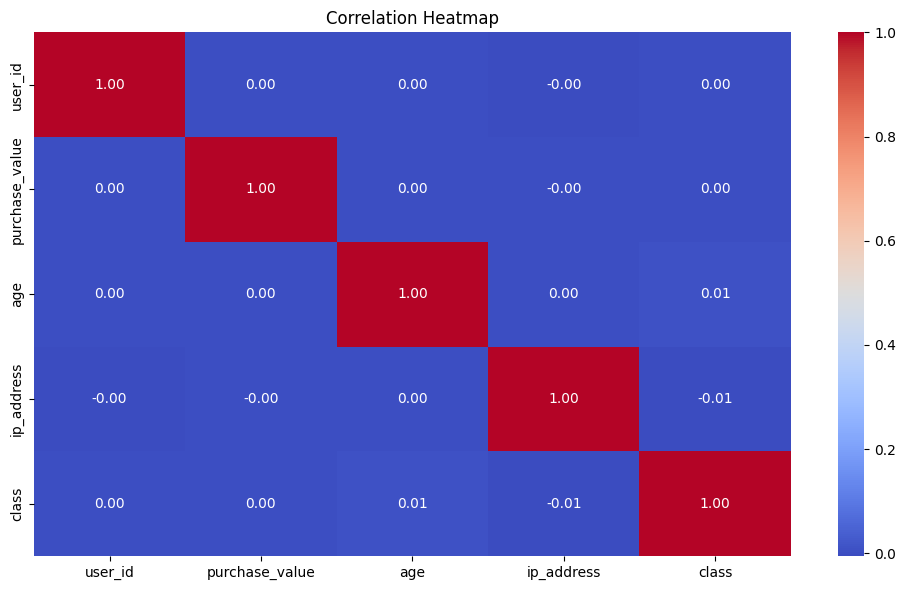

In [8]:
# Categorical features vs fraud class
explorer.plot_categorical_vs_target()

# Numeric features vs fraud class
explorer.plot_numeric_vs_target()

# Correlation heatmap
explorer.correlation_heatmap()


In [9]:
# Create GeoMapper instance
geo = GeoMapper(fraud_df, ip_country_df)

# Convert IP column to int
fraud_df = geo.convert_ip_column()

# Map IPs to countries
fraud_df = geo.map_ip_to_country()

# Quick check
fraud_df[['ip_address', 'country']].head()


,ip_address,country
0,732758368,Japan
1,350311387,United States
2,2621473820,United States
3,3840542443,Unknown
4,415583117,United States


In [10]:
# ---- TIME-BASED FEATURES ----
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.day_name()
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# ---- USER TRANSACTION COUNT ----
# Count number of transactions per user
user_txn_count = fraud_df.groupby('user_id')['purchase_time'].count().rename('user_txn_count')
fraud_df = fraud_df.merge(user_txn_count, on='user_id')

# ---- USER TRANSACTION VELOCITY ----
# Sort by user and purchase time to calculate time gaps between transactions
fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])
fraud_df['prev_purchase_time'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
fraud_df['txn_time_diff'] = (fraud_df['purchase_time'] - fraud_df['prev_purchase_time']).dt.total_seconds()

# Calculate average velocity per user
avg_velocity = fraud_df.groupby('user_id')['txn_time_diff'].mean().rename('user_txn_velocity')
fraud_df = fraud_df.merge(avg_velocity, on='user_id')

# Drop helper columns if no longer needed
fraud_df.drop(columns=['prev_purchase_time', 'txn_time_diff'], inplace=True)

In [11]:
fraud_df[['hour_of_day', 'day_of_week', 'time_since_signup', 'user_txn_count', 'user_txn_velocity']].head()

,hour_of_day,day_of_week,time_since_signup,user_txn_count,user_txn_velocity
0,10,Saturday,3564984.0,1,NaN
1,21,Saturday,10039879.0,1,NaN
2,11,Thursday,6667201.0,1,NaN
3,23,Wednesday,371290.0,1,NaN
4,20,Wednesday,4631485.0,1,NaN


In [12]:
# Drop unneeded columns
X = fraud_df.drop(columns=['class', 'signup_time', 'purchase_time', 'device_id', 'user_id', 'ip_address'])
y = fraud_df['class']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Fill missing values (optional: use other strategy like median if appropriate)
X.fillna(0, inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale numeric columns
numeric_cols = X_train_resampled.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [13]:
# Select numeric columns only
numeric_cols = X_train_resampled.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [14]:
X_train_resampled = pd.get_dummies(X_train_resampled, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Make sure both sets have same columns
X_train_resampled, X_test = X_train_resampled.align(X_test, join='left', axis=1, fill_value=0)


In [16]:
joblib.dump((X_train_resampled, y_train_resampled, X_test, y_test, scaler), 'preprocessed_data.pkl')

['preprocessed_data.pkl']